In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go


plt.rcParams['figure.figsize'] = [12, 7]

plt.rc('font', size=14) 


In [112]:
historical_data = pd.read_csv("data/AAPL_historical_data.csv")
historical_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,130.279999,130.899994,124.169998,125.070000,123.904633,112117500
1,2023-01-04,126.889999,128.660004,125.080002,126.360001,125.182617,89113600
2,2023-01-05,127.129997,127.769997,124.760002,125.019997,123.855103,80962700
3,2023-01-06,126.010002,130.289993,124.889999,129.619995,128.412216,87754700
4,2023-01-09,130.470001,133.410004,129.889999,130.149994,128.937286,70790800


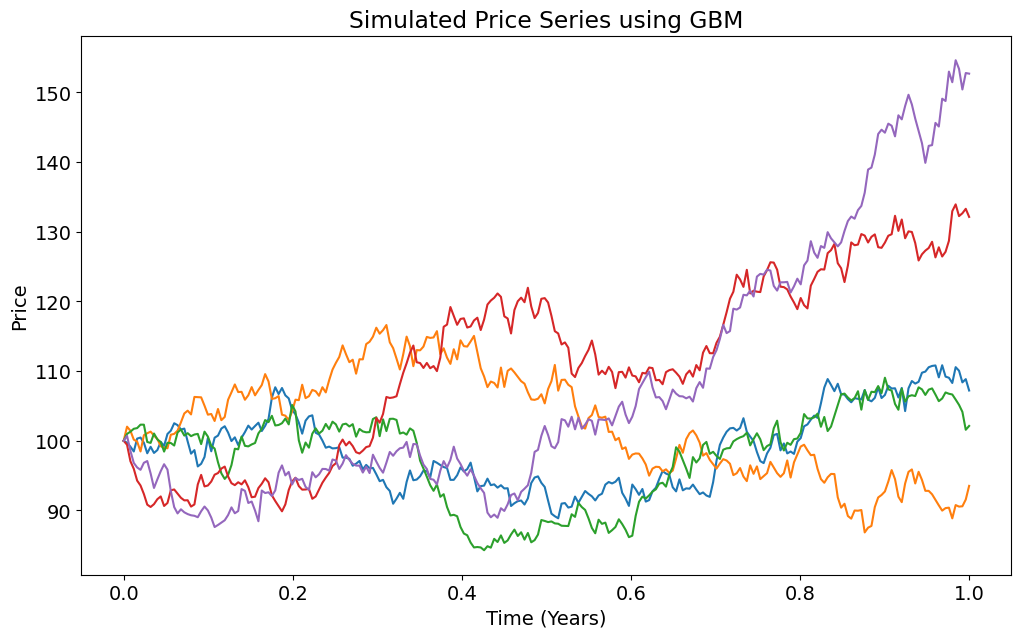

In [113]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm(S0, mu, sigma, T, dt, N):
    """
    Simulate price series using the Geometric Brownian Motion (GBM) model.
    
    Args:
    S0 (float): Initial asset price.
    mu (float): Drift (expected return).
    sigma (float): Volatility.
    T (float): Total time in years.
    dt (float): Time step size.
    N (int): Number of simulations.
    
    Returns:
    np.ndarray: Simulated price series.
    """
    np.random.seed(42)  # Fixing seed for reproducibility
    timesteps = int(T / dt)
    time = np.linspace(0, T, timesteps)
    
    # Generate random noise for each simulation
    W = np.random.standard_normal((timesteps, N))
    
    # Calculate the GBM process
    S = np.zeros_like(W)
    S[0] = S0
    for t in range(1, timesteps):
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * W[t])
    
    return S, time

# Example usage:
S0 = 100  # Initial price
mu = 0.05  # Drift
sigma = 0.2  # Volatility

T = 1.0  # 1 year
dt = 1/252  # Daily steps
N = 5  # Number of simulated paths

simulated_data, time = simulate_gbm(S0, mu, sigma, T, dt, N)

# Plot the simulated data
plt.plot(time, simulated_data)
plt.title("Simulated Price Series using GBM")
plt.xlabel("Time (Years)")
plt.ylabel("Price")
plt.show()


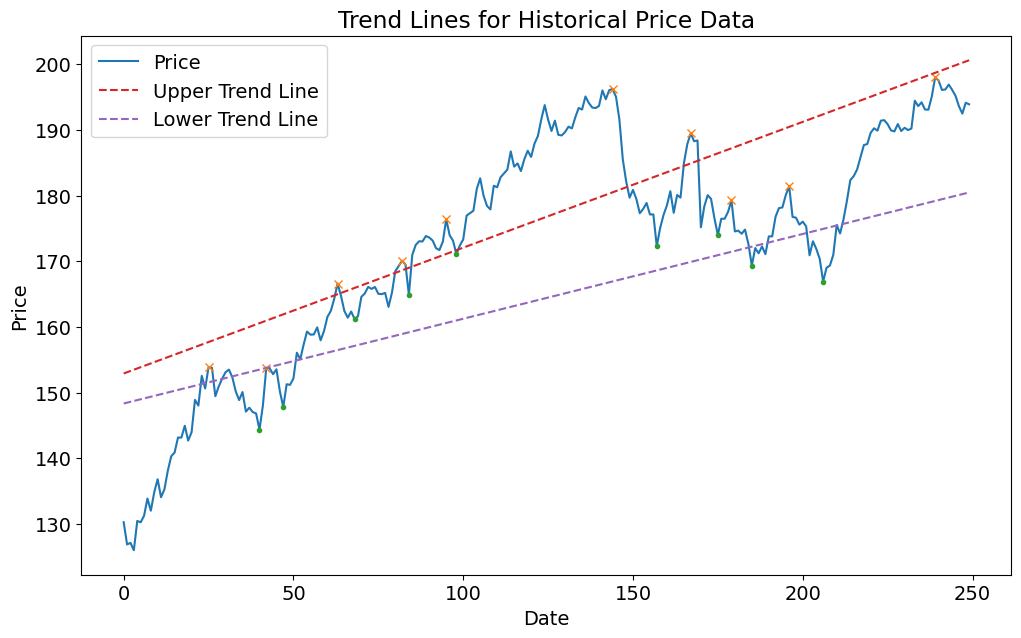

In [131]:
def generate_trend_lines(prices, log_transform=False):
    """
    Automatically generate trend lines for the given price series.
    
    Args:
    prices (pd.Series or np.ndarray): The price series.
    log_transform (bool): Whether to apply log transformation to the price series.
    
    Returns:
    tuple: A tuple containing the upper and lower trend lines.
    """
    if log_transform:
        prices = np.log(prices)
    
    # Identify peaks (upper) and troughs (lower)
    peaks, _ = find_peaks(prices, prominence=5)
    troughs, _ = find_peaks(-prices, prominence=5)

    
    
    # Fit linear regressions to peaks and troughs
    reg_upper = LinearRegression().fit(peaks.reshape(-1, 1), prices[peaks])
    reg_lower = LinearRegression().fit(troughs.reshape(-1, 1), prices[troughs])
    
    # Generate the trend lines
    trend_upper = reg_upper.predict(np.arange(len(prices)).reshape(-1, 1))
    trend_lower = reg_lower.predict(np.arange(len(prices)).reshape(-1, 1))
    
    return peaks, troughs, trend_upper, trend_lower

# Example usage:
data = historical_data["Open"]
dates = historical_data["Date"]
peaks, troughs, trend_upper, trend_lower = generate_trend_lines(data)

# Plot the results
plt.plot(data, label='Price')
plt.plot(data[peaks], 'x')
plt.plot(data[troughs], '.')
plt.plot(trend_upper, label='Upper Trend Line', linestyle='--')
plt.plot(trend_lower, label='Lower Trend Line', linestyle='--')
plt.title("Trend Lines for Historical Price Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [121]:
class AssetLevels:
    def __init__(self, historical_data: pd.DataFrame):
        self.df = historical_data  # Store the historical data as a class attribute
        # self.s = np.mean(self.df['High'] - self.df['Low'])/2  # Average range for detecting levels
        self.s = 0
        self.levels = []  # All detected levels (support and resistance)
        self.supports = []  # Detected support levels
        self.resistances = []  # Detected resistance levels
        self.populateLevels()

    def isSupport(self, i):
        """
        Checks if a point is a support level (local minimum).
        """
        df = self.df
        support = df['Low'][i] < df['Low'][i-1] and df['Low'][i] < df['Low'][i+1] \
                  and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]
        return support

    def isResistance(self, i):
        """
        Checks if a point is a resistance level (local maximum).
        """
        df = self.df
        resistance = df['High'][i] > df['High'][i-1] and df['High'][i] > df['High'][i+1] \
                     and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2]
        return resistance

    def isFarFromLevel(self, l):
        """
        Checks if the detected level is far enough from existing levels to be considered new.
        """
        return np.sum([abs(l - x) < self.s for x in self.levels]) == 0

    def populateLevels(self):
        """
        Detects all support and resistance levels in the data and stores them.
        """
        for i in range(2, self.df.shape[0] - 2):
            if self.isSupport(i):
                l = self.df['Low'][i]
                if self.isFarFromLevel(l):
                    self.supports.append((i, l))  # Add support to list
                    self.levels.append(l)  # Track all levels
                
            elif self.isResistance(i):
                l = self.df['High'][i]
                if self.isFarFromLevel(l):
                    self.resistances.append((i, l))  # Add resistance to list
                    self.levels.append(l)  # Track all levels
        return self.supports, self.resistances
    def getLevels(self):
        """
        Returns a tuple of (supports, resistances)
        """
        return np.array(self.supports), np.array(self.resistances)
            


In [125]:
aapl = AssetLevels(historical_data)
supports, resistances = aapl.getLevels()

In [127]:
fig = go.Figure(data=[go.Candlestick(x=historical_data['Date'],
                open=historical_data['Open'],
                high=historical_data['High'],
                low=historical_data['Low'],
                close=historical_data['Close'])])

# plot supports
fig.add_trace(go.Scatter(x=historical_data["Date"][supports[:,0]], y=supports[:,1], mode='markers', marker_color='blue', name="Support Levels"))
fig.add_trace(go.Scatter(x=historical_data["Date"][resistances[:,0]], y=resistances[:,1], mode='markers', marker_color='brown', name="Resistance Levels"))
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()



